In [1]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import concurrent.futures as mp
from typing import Union

Sources:

https://cds.cern.ch/record/2257069?ln=en

https://atlas.physicsmasterclasses.org/en/zpath_lhcphysics2.htm

inspiração para filtros:

https://github.com/Introducao-AnaliseDados-FAE/IntroducaoAnalisedeDadosFAE-2024_02/blob/main/material/aula_8/aulaMatheusCosta_26Nov2024.pdf


fonte para os labels dos dados:

https://cms-opendata-workshop.github.io/workshop2024-lesson-physics-objects/aio.html

para luminosidade (?):

https://cms-opendata-guide.web.cern.ch/analysis/lumi/


In [2]:
FILTER_MASS = True
MASS_MIN = 60
MASS_MAX = 120
BINS = 30
DPI = 500

def inv_mass(ak_vec1: ak.Array, ak_vec2: ak.Array) -> ak.Array:
    return ak.flatten(np.sqrt(
        2 * ak_vec1.pt * ak_vec2.pt * (np.cosh(ak_vec1.eta - ak_vec2.eta) - np.cos(ak_vec1.phi - ak_vec2.phi))
    ))

def expand(ak_array: ak.Array) -> tuple[ak.Array, ak.Array]:
    pairs = ak.combinations(ak_array, 2)
    return ak.unzip(pairs)

def inv_mass_expand(ak_array: ak.Array) -> ak.Array:
    vec1, vec2 = expand(ak_array)
    mass = inv_mass(vec1, vec2)
    if FILTER_MASS:
        mass = mass[(mass > MASS_MIN) & (mass < MASS_MAX)]
    return mass

def generete_data(file_path: str, branches: list[str]) -> ak.Array:
    with uproot.open(file_path) as file:
        tree = file['Events']
        arrays = {branch.split("_")[-1].lower(): tree[branch].array() for branch in branches}
    return ak.zip(arrays)

def hist_plot(ak_array: Union[ak.Array, np.ndarray],
              column_name: str,
              display_name: str = None, **kwargs):
    plt.hist(ak.flatten(ak_array[column_name]) if isinstance(ak_array, ak.Array) else ak_array, **kwargs)
    plt.xlabel(display_name if display_name else column_name)
    plt.ylabel("Eventos")

def generate_points(mass):
    hist_counts, bin_edges = np.histogram(mass, bins=BINS)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) * 0.5
    return bin_centers, hist_counts

Fonte dos dados:

In [3]:
data = "root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/DYJetsToLL_M-50_TuneCP5_13TeV-amcatnloFXFX-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/30000/0082C29D-E74C-024A-BE9B-97B29EE7A4A2.root" 
realdata = "root://eospublic.cern.ch//eos/opendata/cms/Run2016G/DoubleMuon/NANOAOD/UL2016_MiniAODv2_NanoAODv9-v2/2430000/05DD095C-F6C3-9A4F-9FB3-348A5A6403D5.root"

colunas que iremos selecionar:

In [4]:
branches = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge", "nMuon", "Muon_tkRelIso", "Muon_sip3d"]

In [5]:
vec_real = generete_data(realdata, branches)
vec = generete_data(data, branches)

quantidade de dados:

In [6]:
print(f"Real data: {len(vec_real)}")
print(f"Simulated data: {len(vec)}")

Real data: 2315223
Simulated data: 1933726


# Plots

aqui vamos plotar a comparação entre os dados simulados (MC) e os dados reais coletados pelo LHC

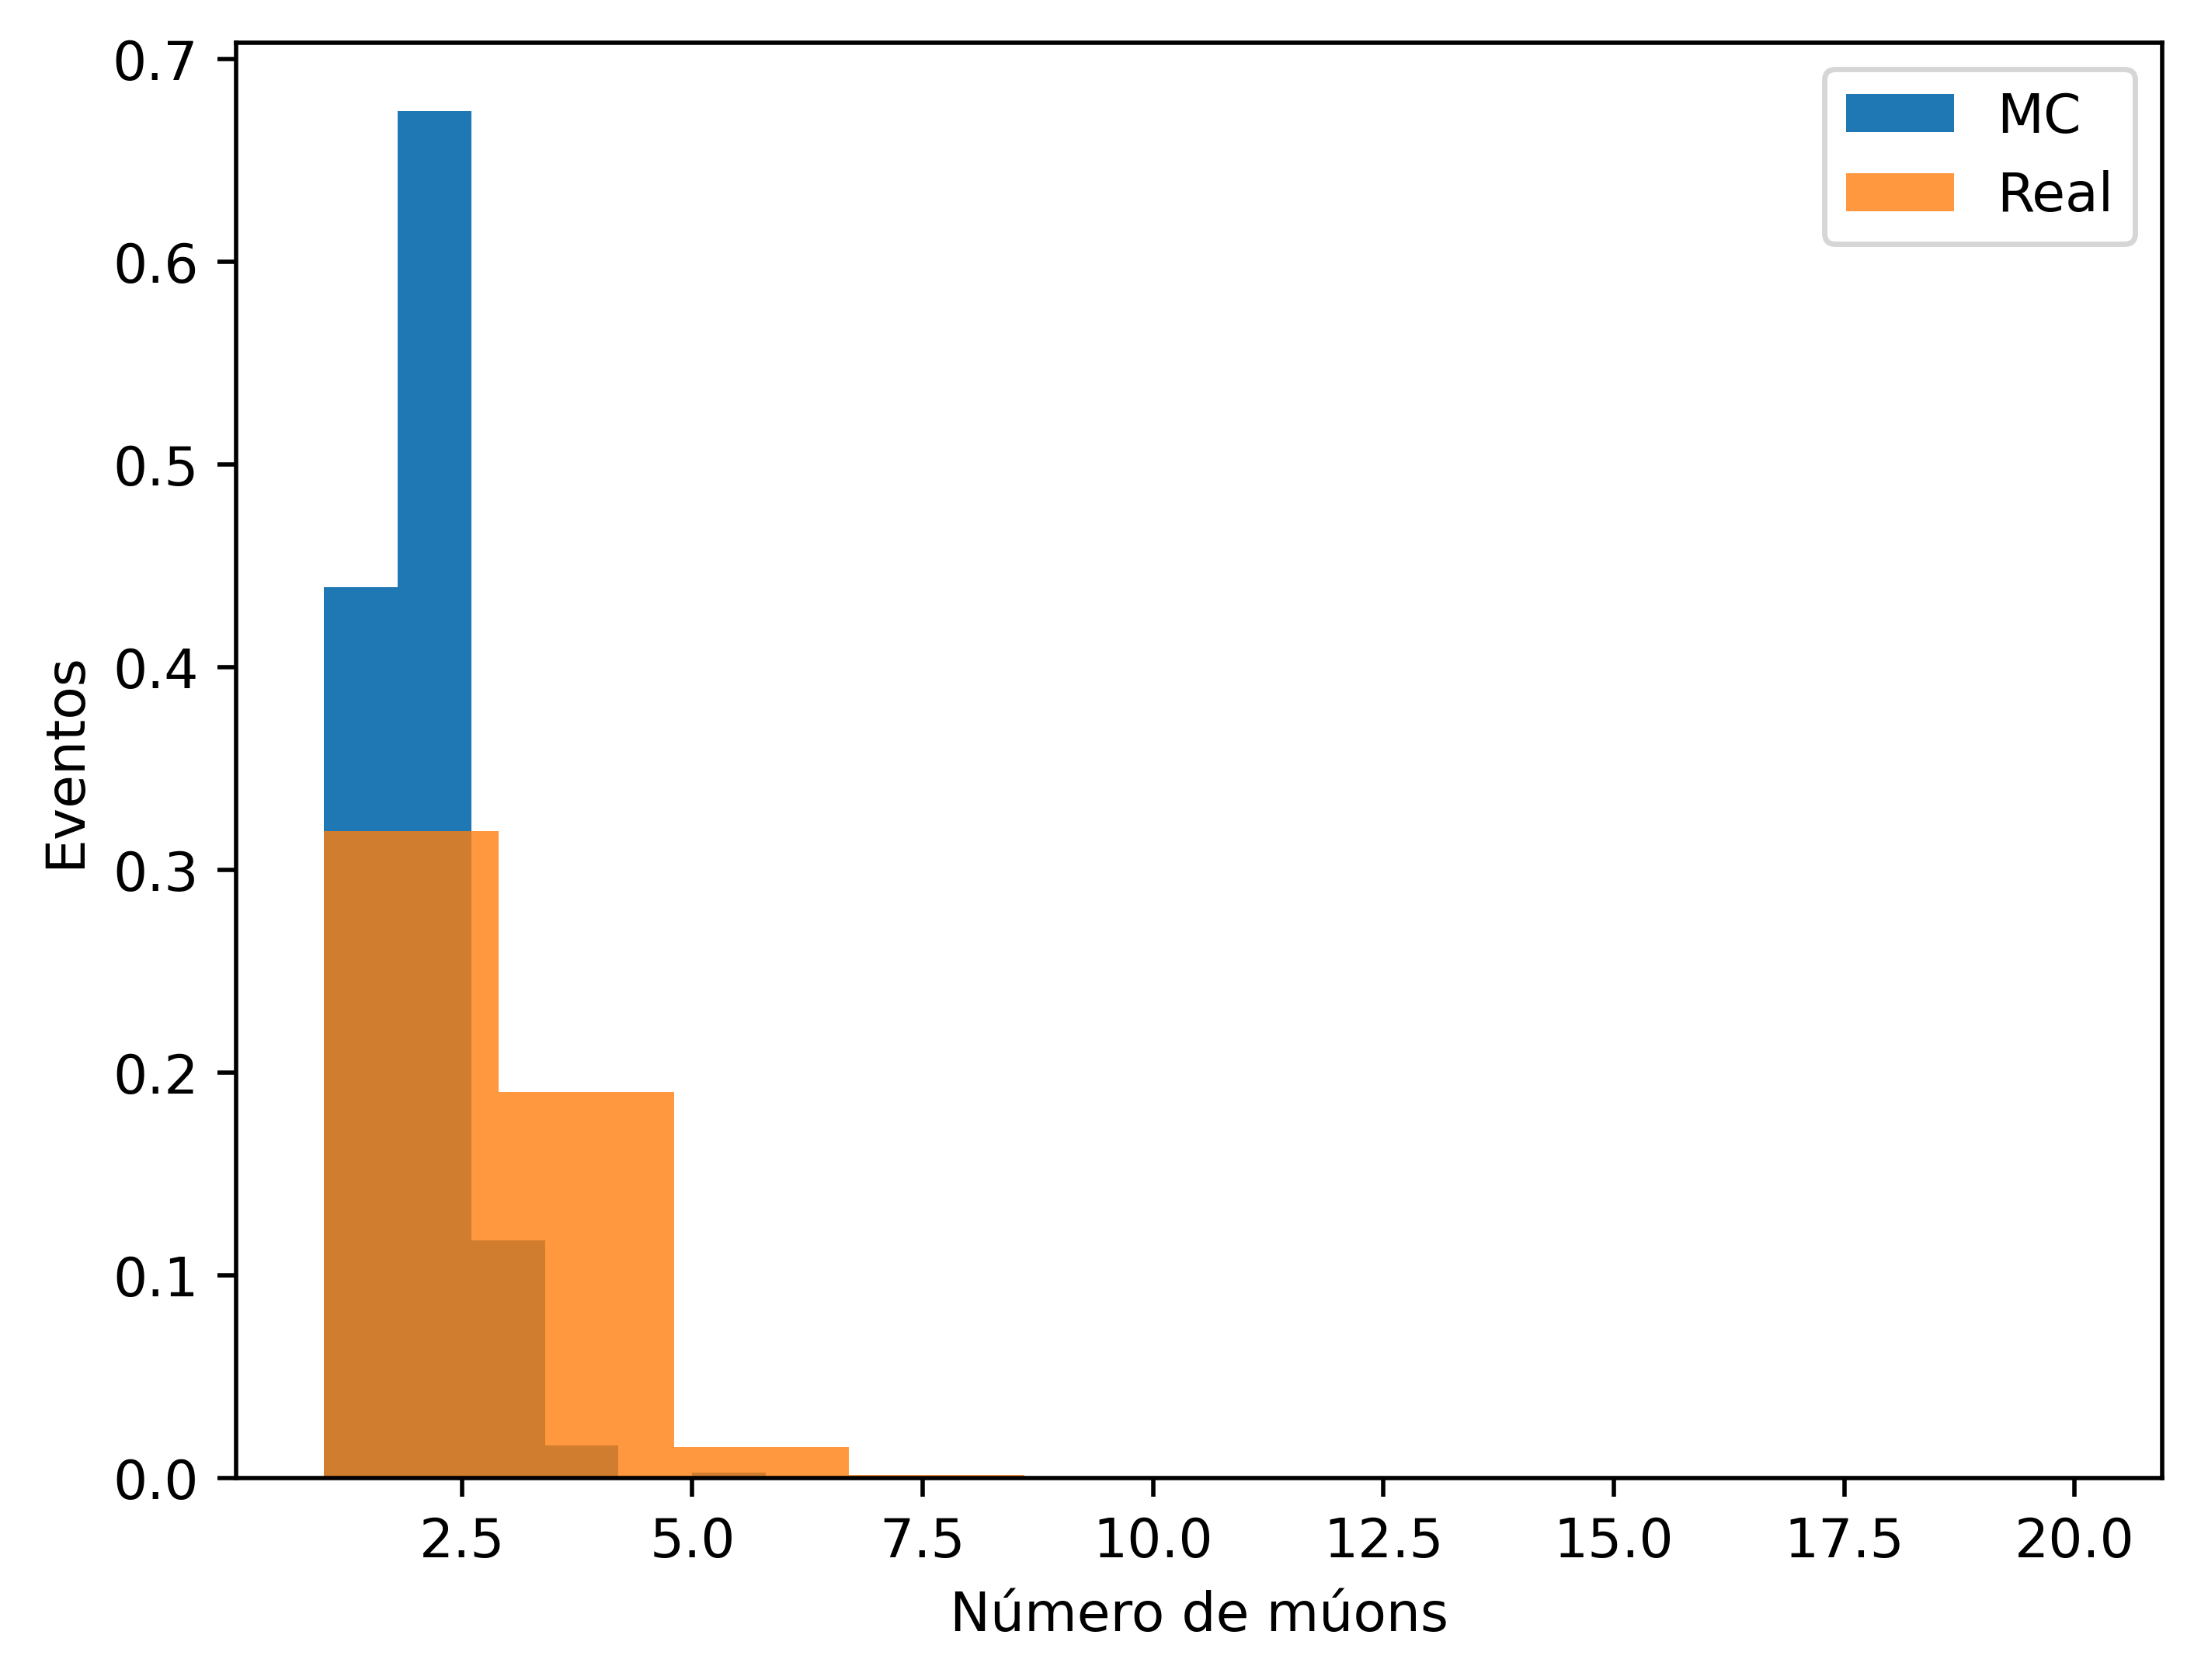

In [7]:
plt.figure(dpi=DPI)
hist_plot(vec, "nmuon", "Número de múons", label="MC", density=True)
hist_plot(vec_real, "nmuon", "Número de múons", label="Real", density=True, alpha=0.8)
plt.legend()
plt.show()

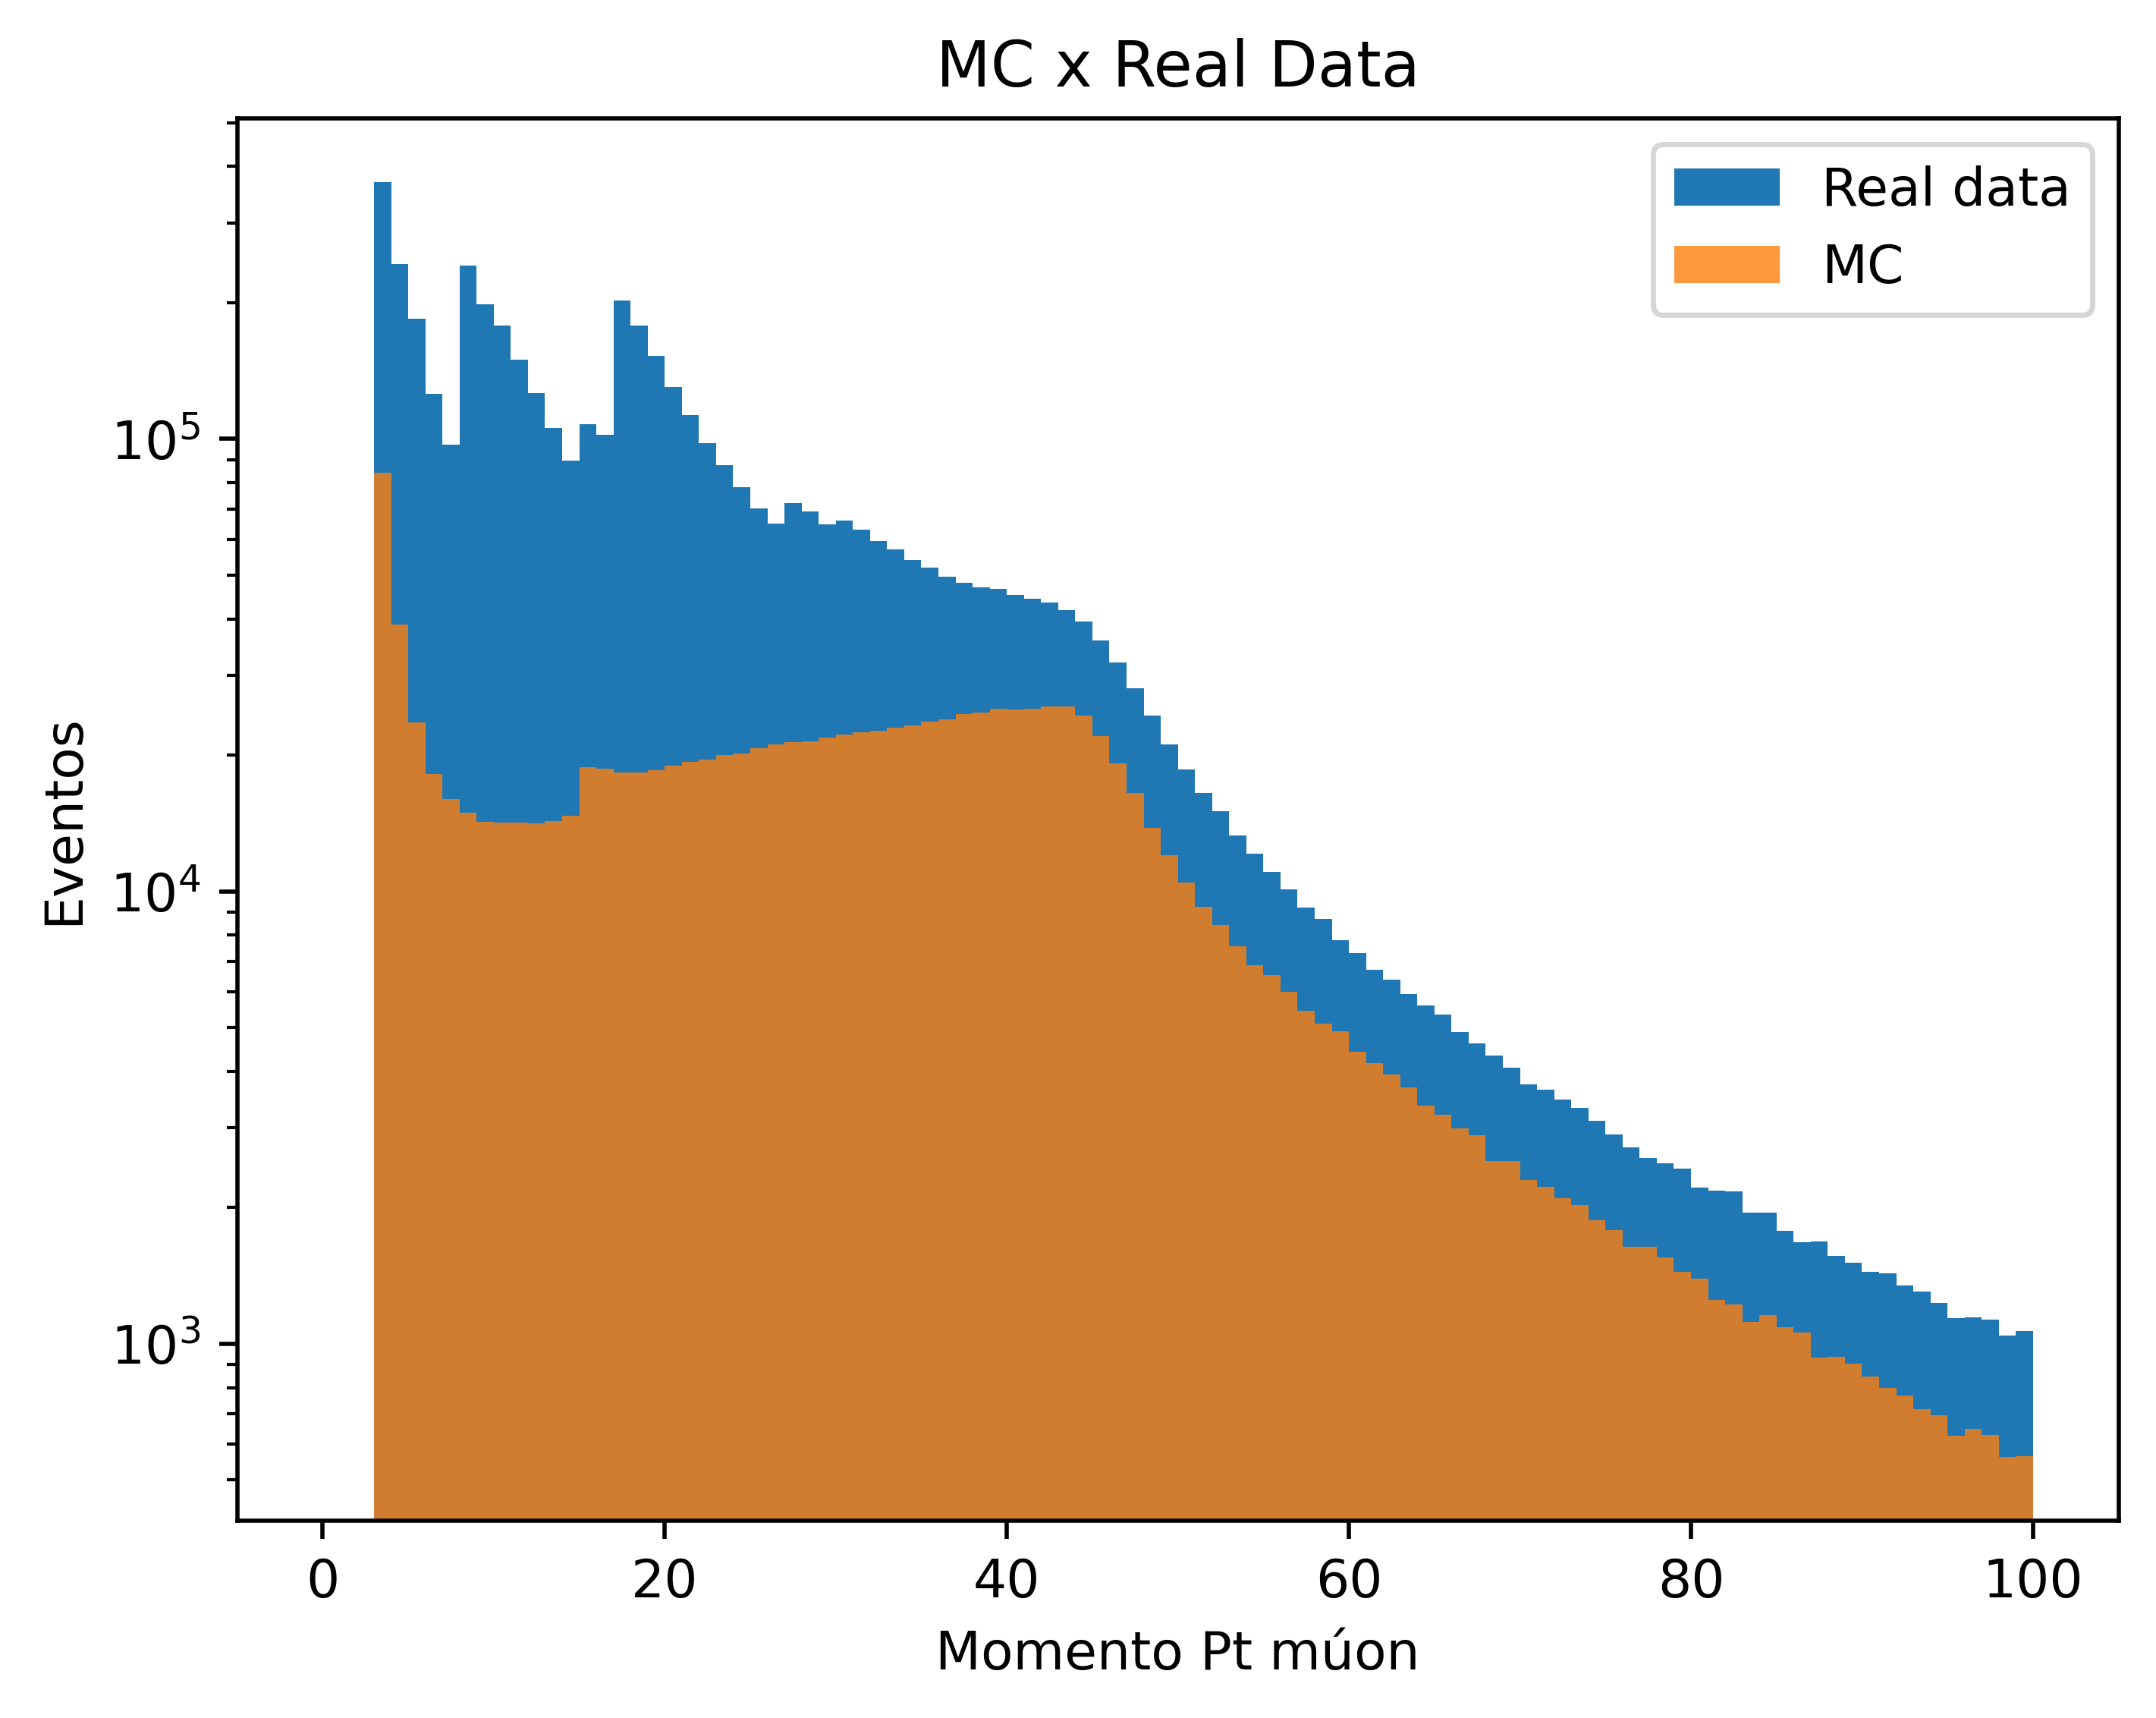

In [8]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "pt" , "Momento Pt múon", bins=100, range=(0, 100), log=True, label="Real data")
hist_plot(vec, "pt" , "Momento Pt múon", bins=100, range=(0, 100), log=True, label="MC", alpha=0.8)
plt.title("MC x Real Data")
plt.legend()
plt.show()

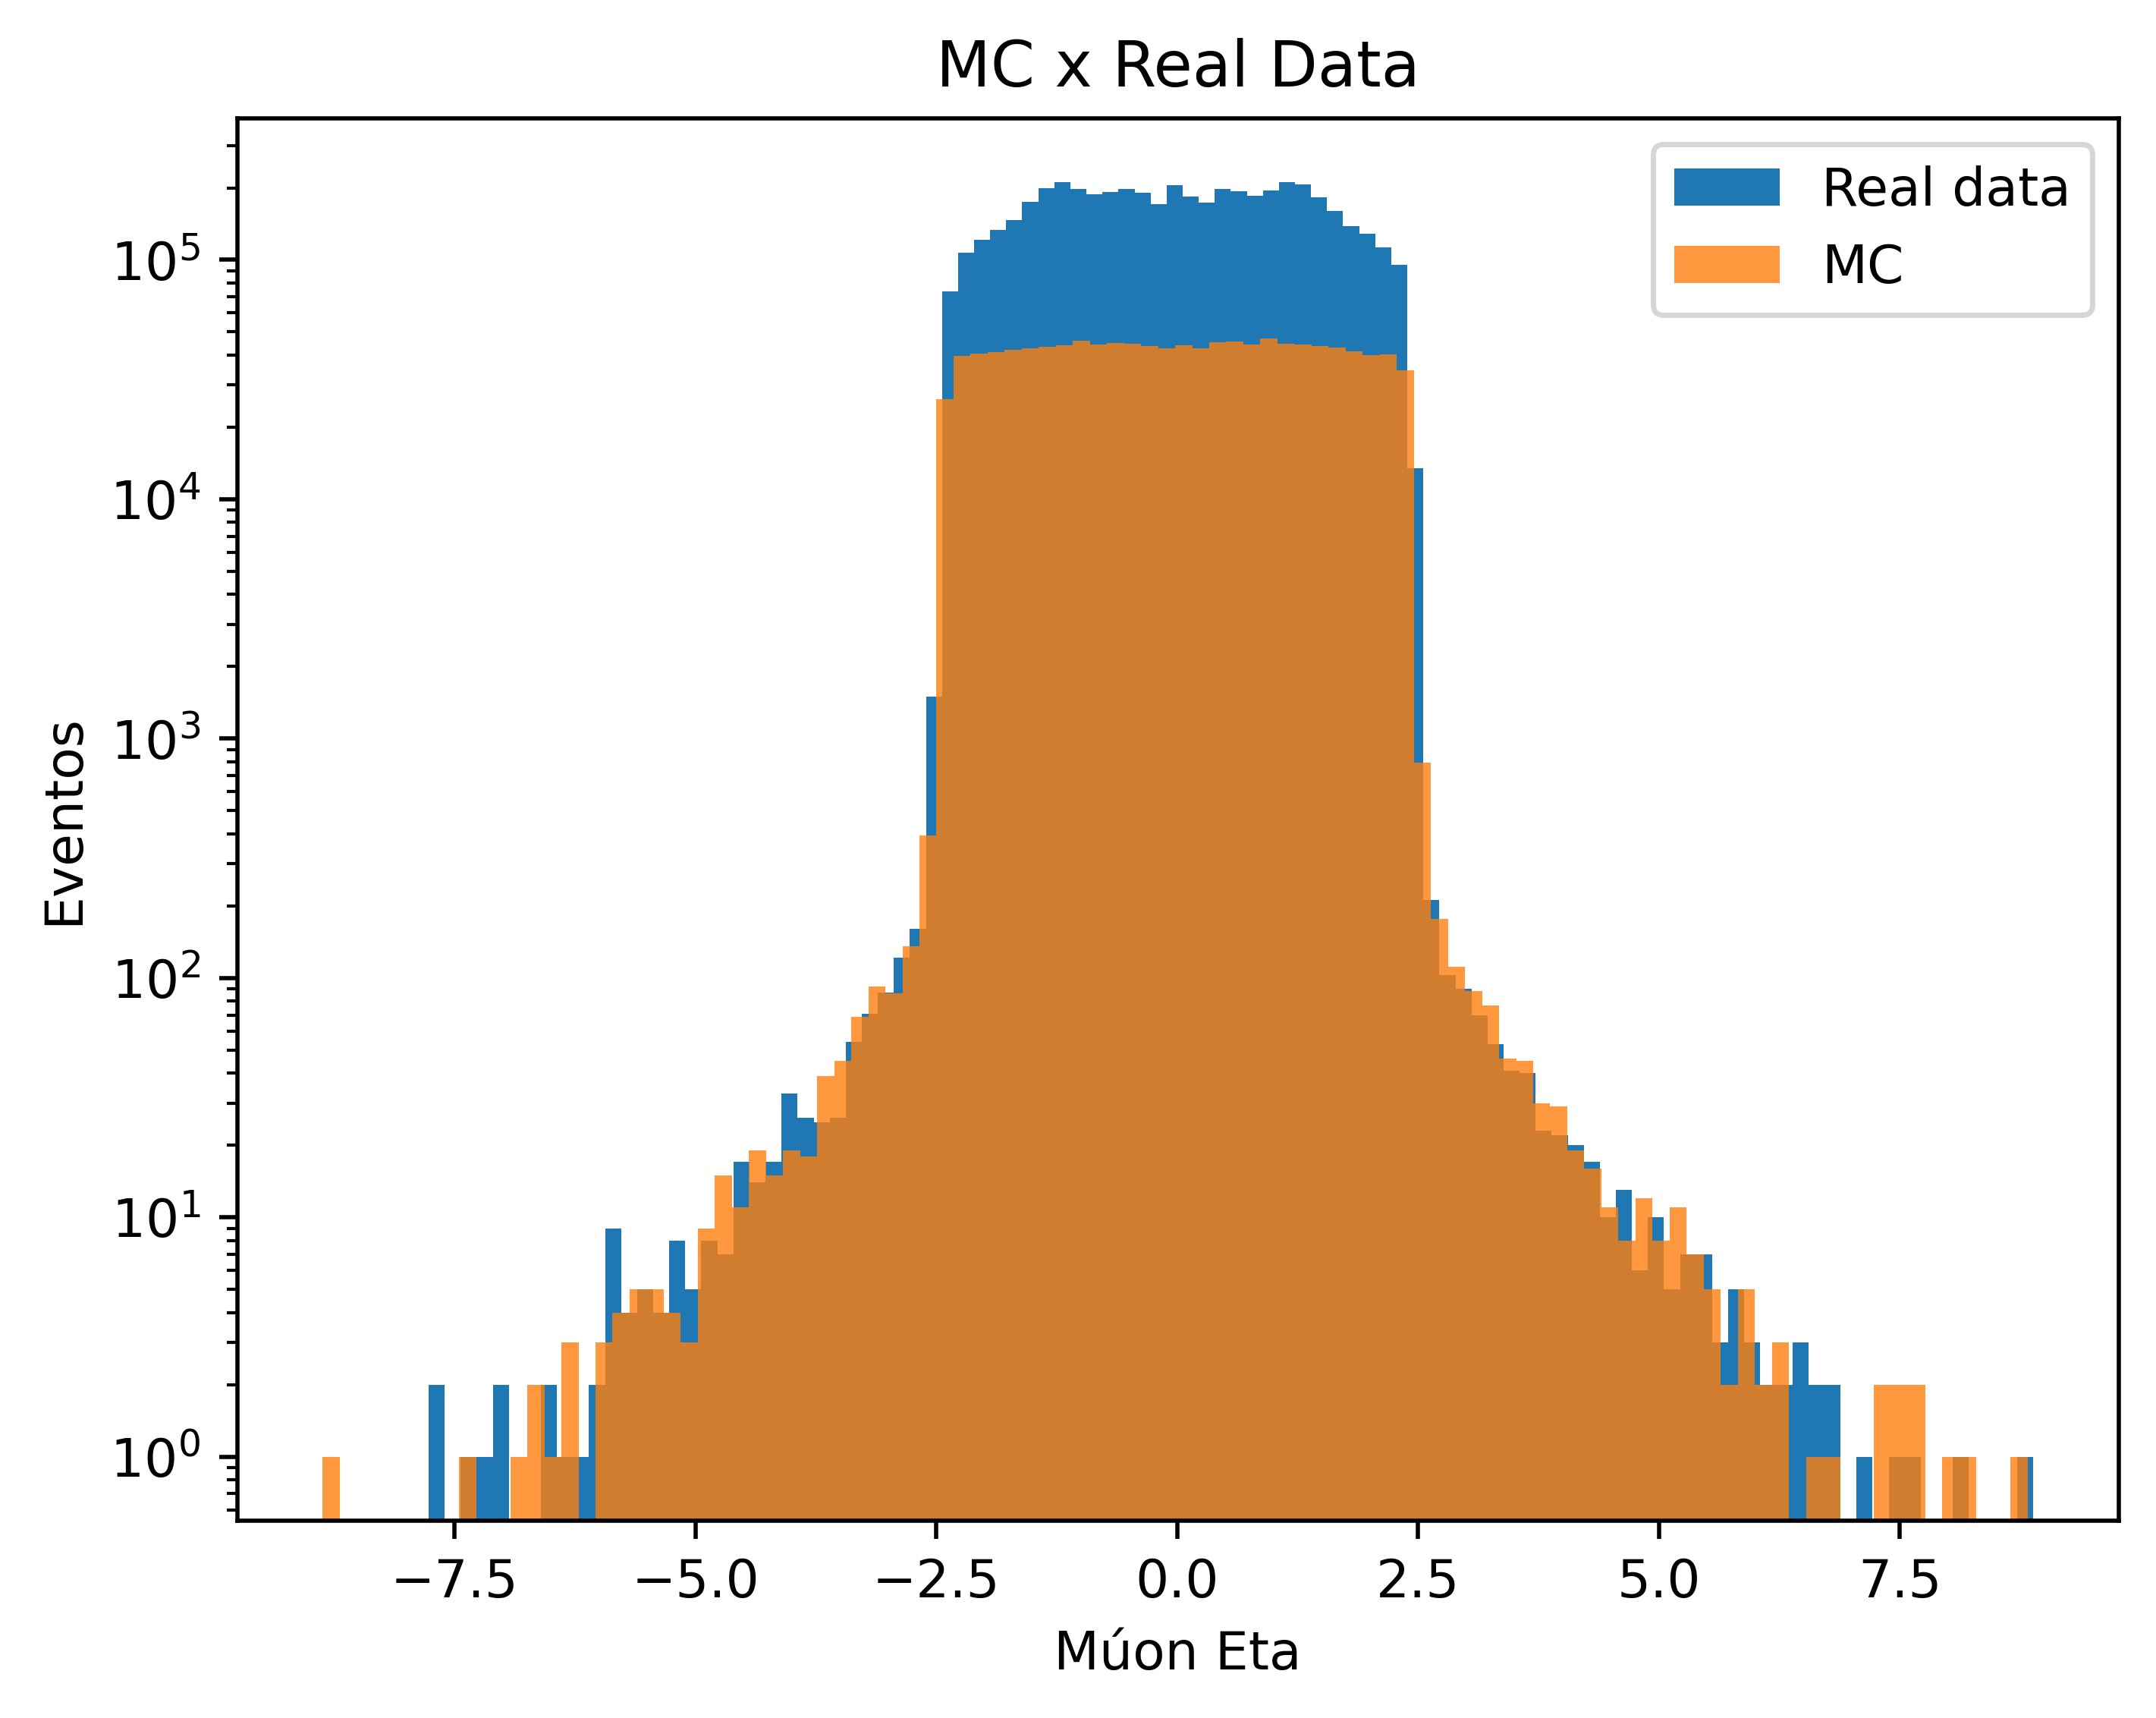

In [9]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "eta" , "Múon Eta", bins=100, log=True, label="Real data")
hist_plot(vec, "eta" , "Múon Eta", bins=100, log=True, label="MC", alpha=0.8)
plt.title("MC x Real Data")
plt.legend()
plt.show()

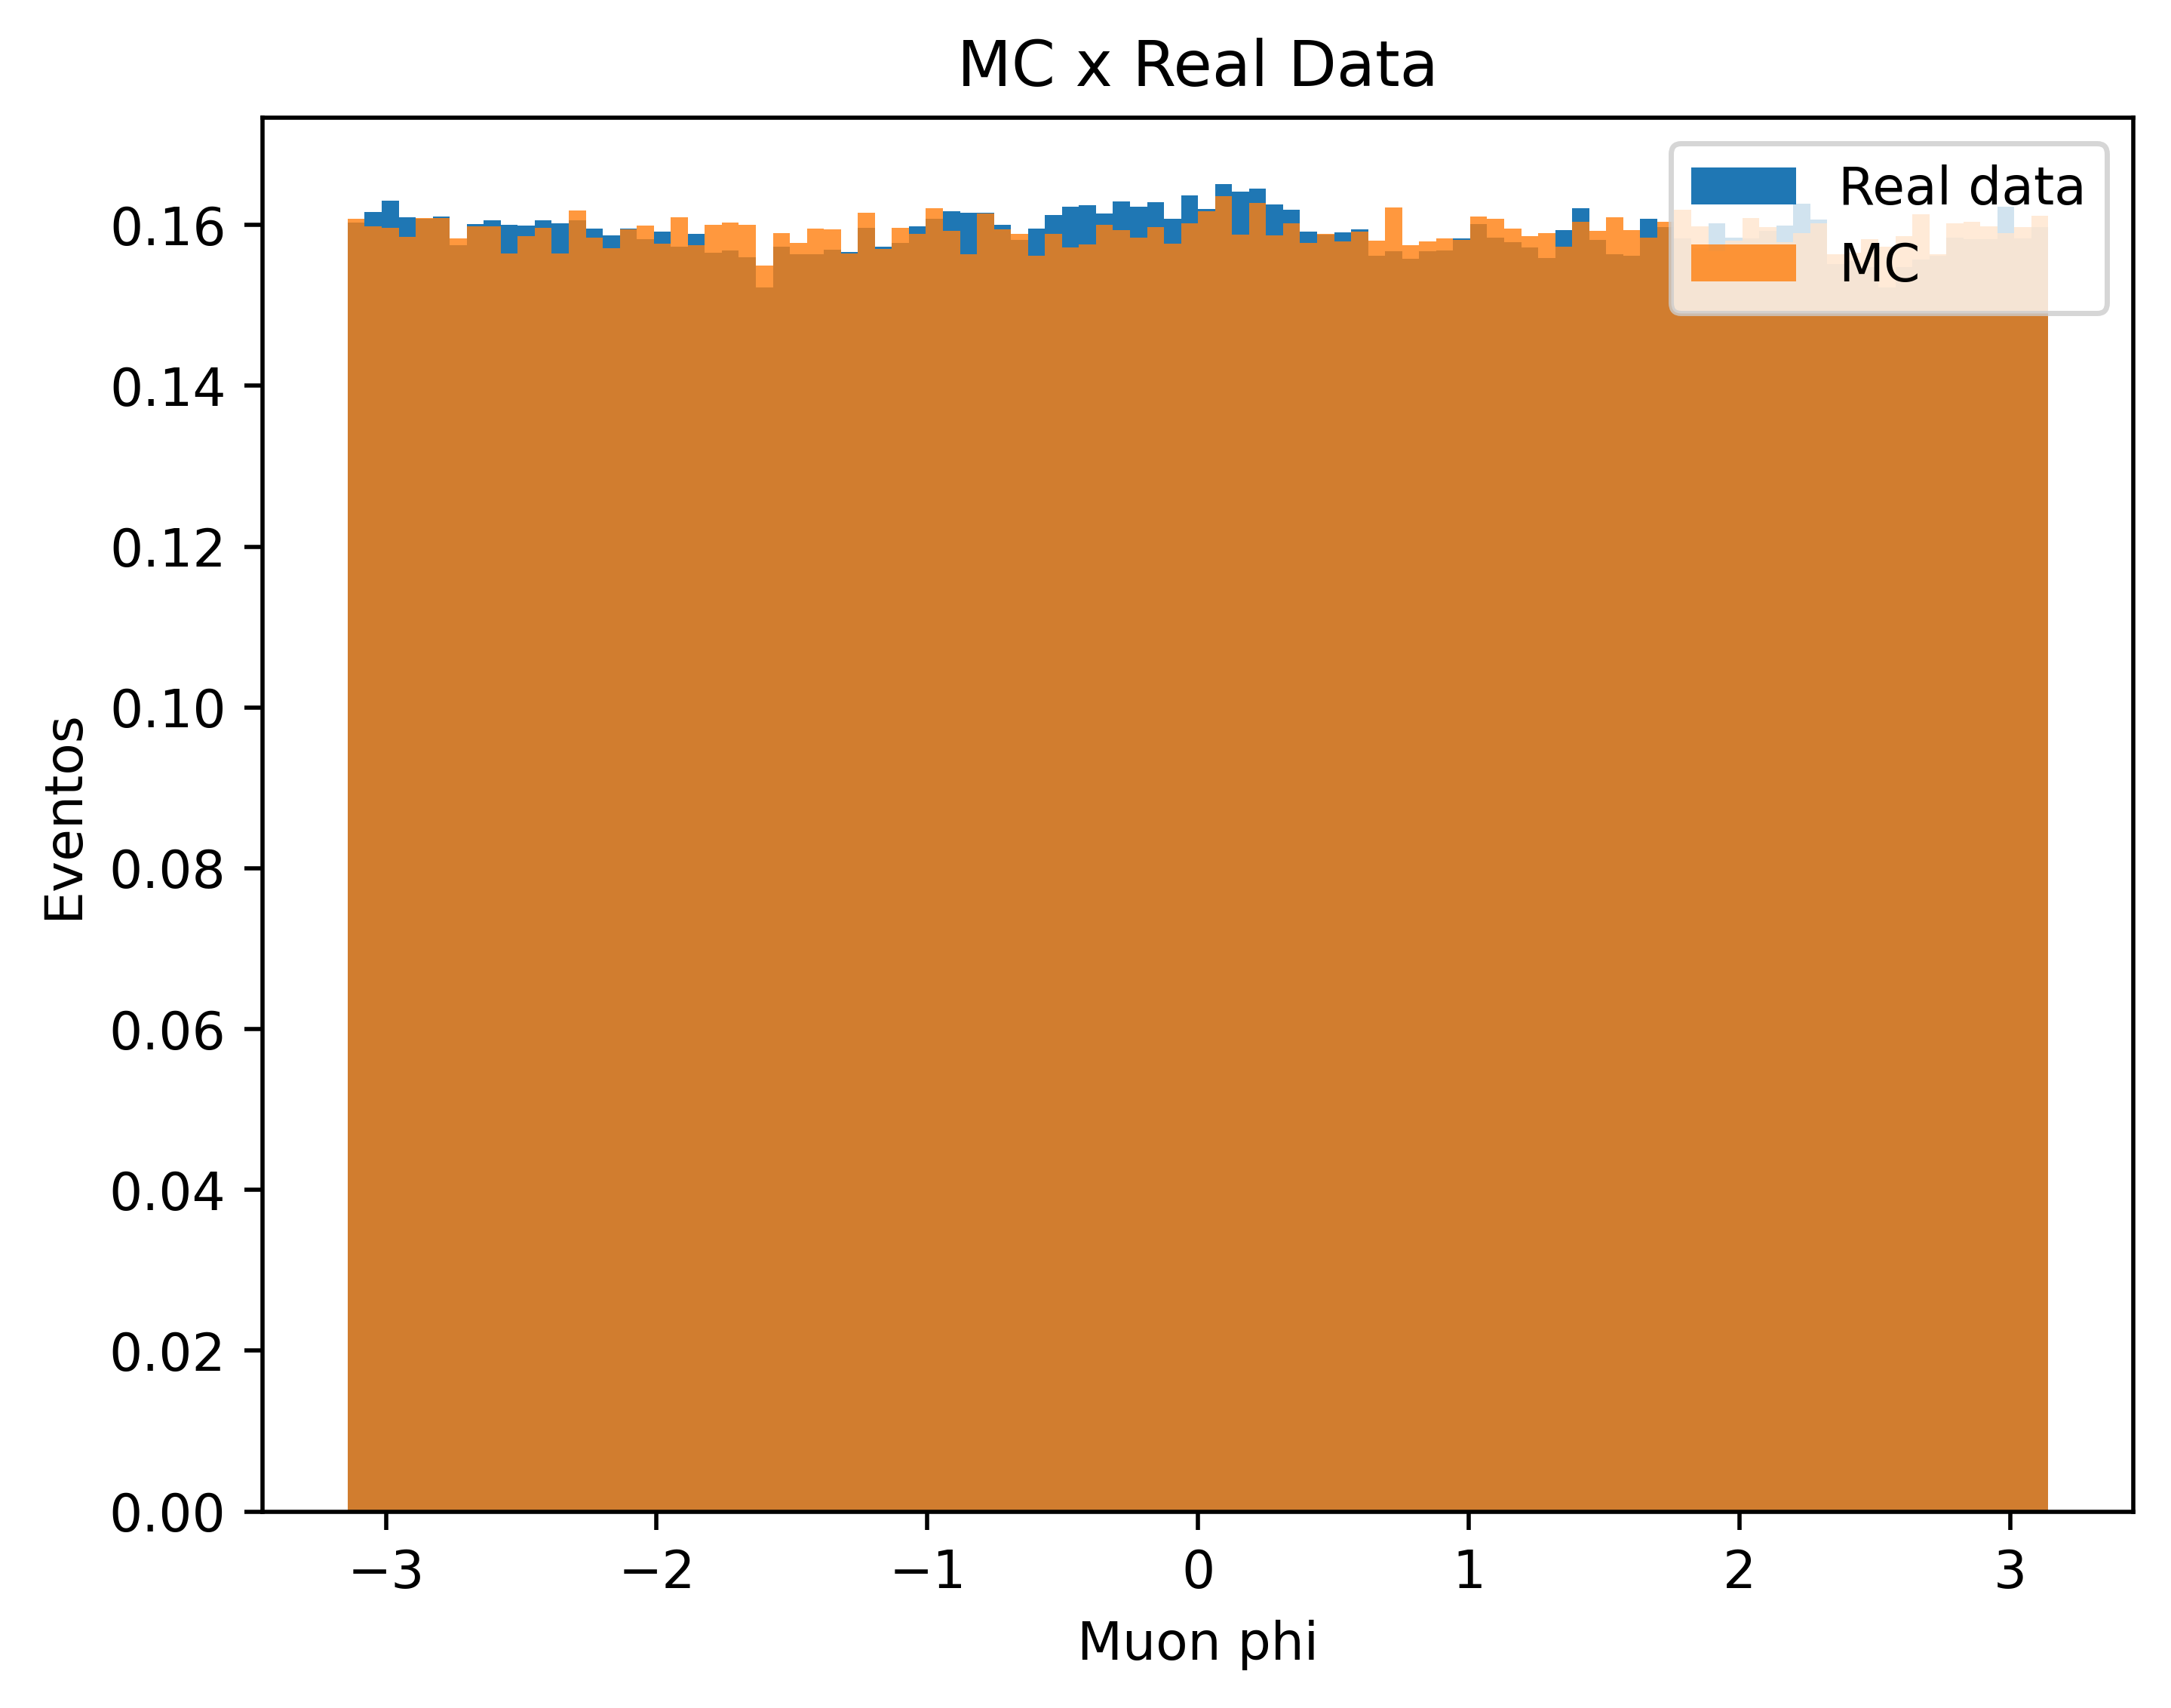

In [10]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "phi" , "Muon phi", bins=100, label="Real data", density=True)
hist_plot(vec, "phi" , "Muon phi", bins=100, label="MC", density=True, alpha=0.8)
plt.title("MC x Real Data")
plt.legend()
plt.show()

In [ ]:
mass_real = inv_mass_expand(vec_real)
mass = inv_mass_expand(vec)

bin_centers, hist_counts = generate_points(mass_real)

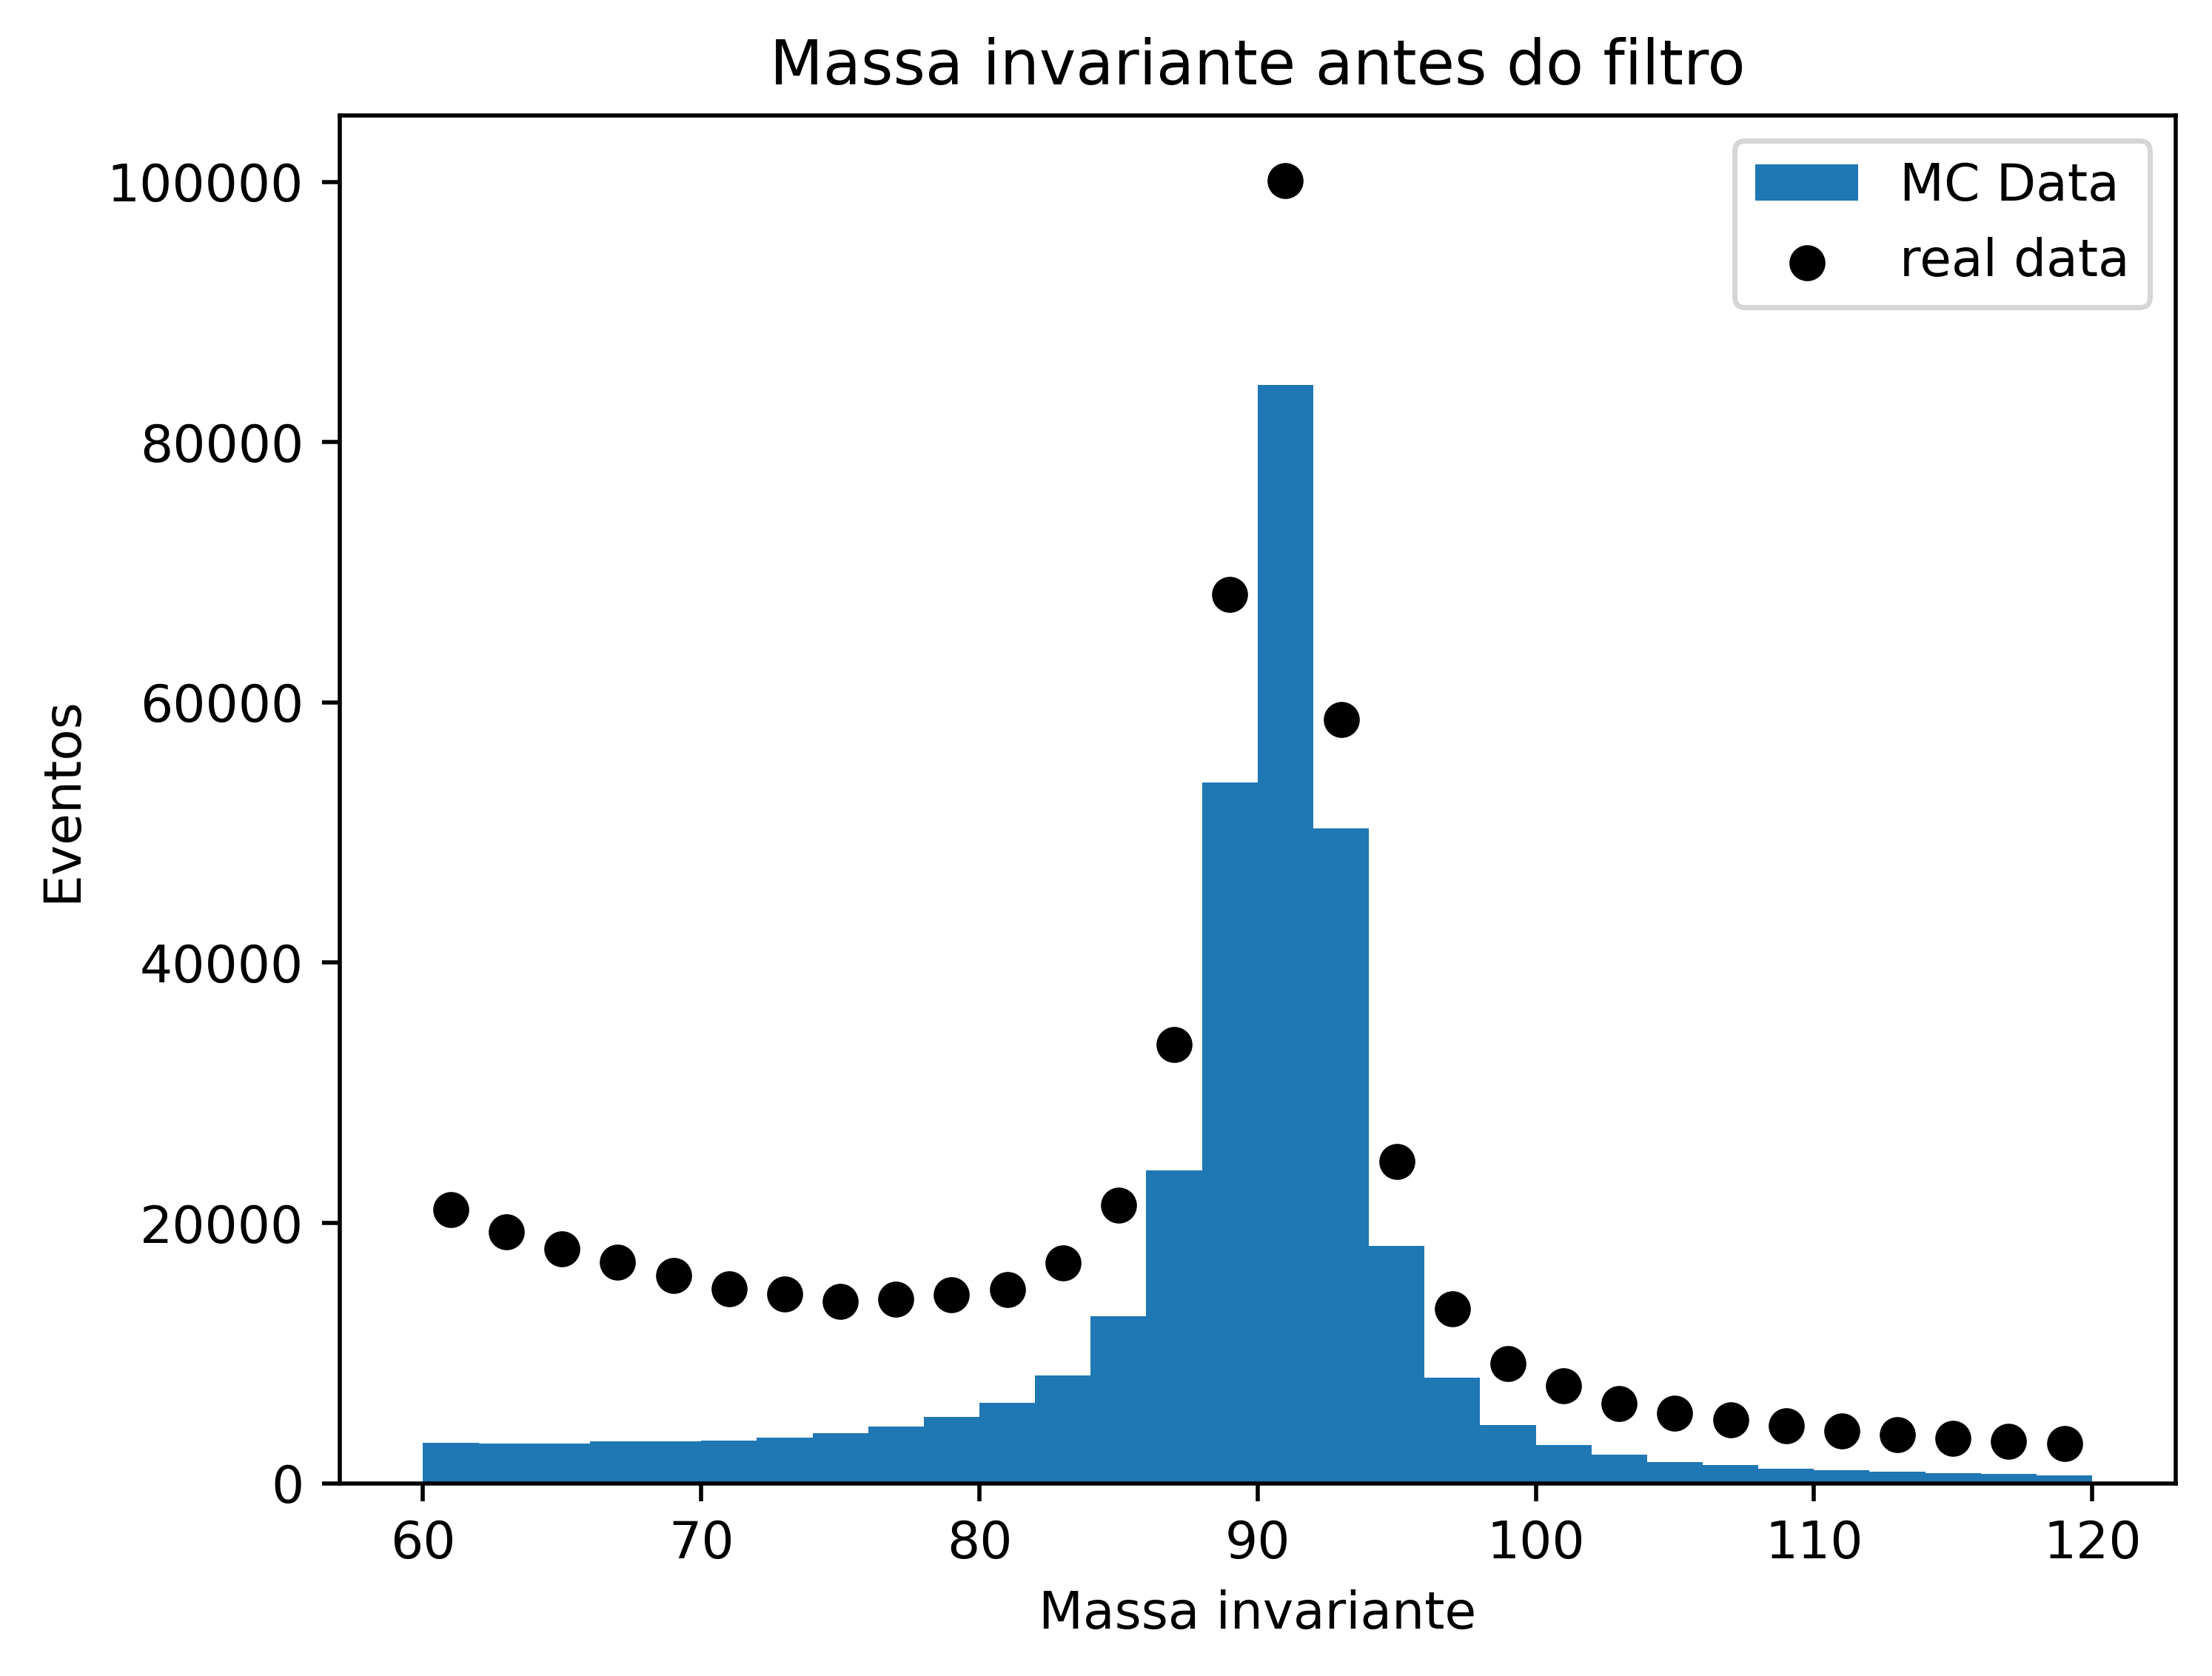

In [ ]:
plt.figure(dpi=DPI)
plt.hist(mass, bins=BINS, label="MC Data")
plt.scatter(bin_centers, hist_counts, label="real data", color="black")
plt.xlabel("Massa invariante")
plt.ylabel("Eventos")
plt.title("Massa invariante antes do filtro")
plt.legend()
plt.show()

# Aplicando filtros

O evento que queremos estudar é:

Z -> mu+ mu-

Então:

In [ ]:
# filtrando para garantir que vamos ter apenas 2 muons
filtered_real = vec_real[ak.num(vec_real) == 2]

# como só temos 2 muons, se somar a carga deles e der 0, significa que são de cargas opostas
filtered_real = filtered_real[ak.sum(filtered_real.charge, axis=1) == 0]

filtered = vec[ak.num(vec) == 2]
filtered = filtered[ak.sum(filtered.charge, axis=1) == 0]

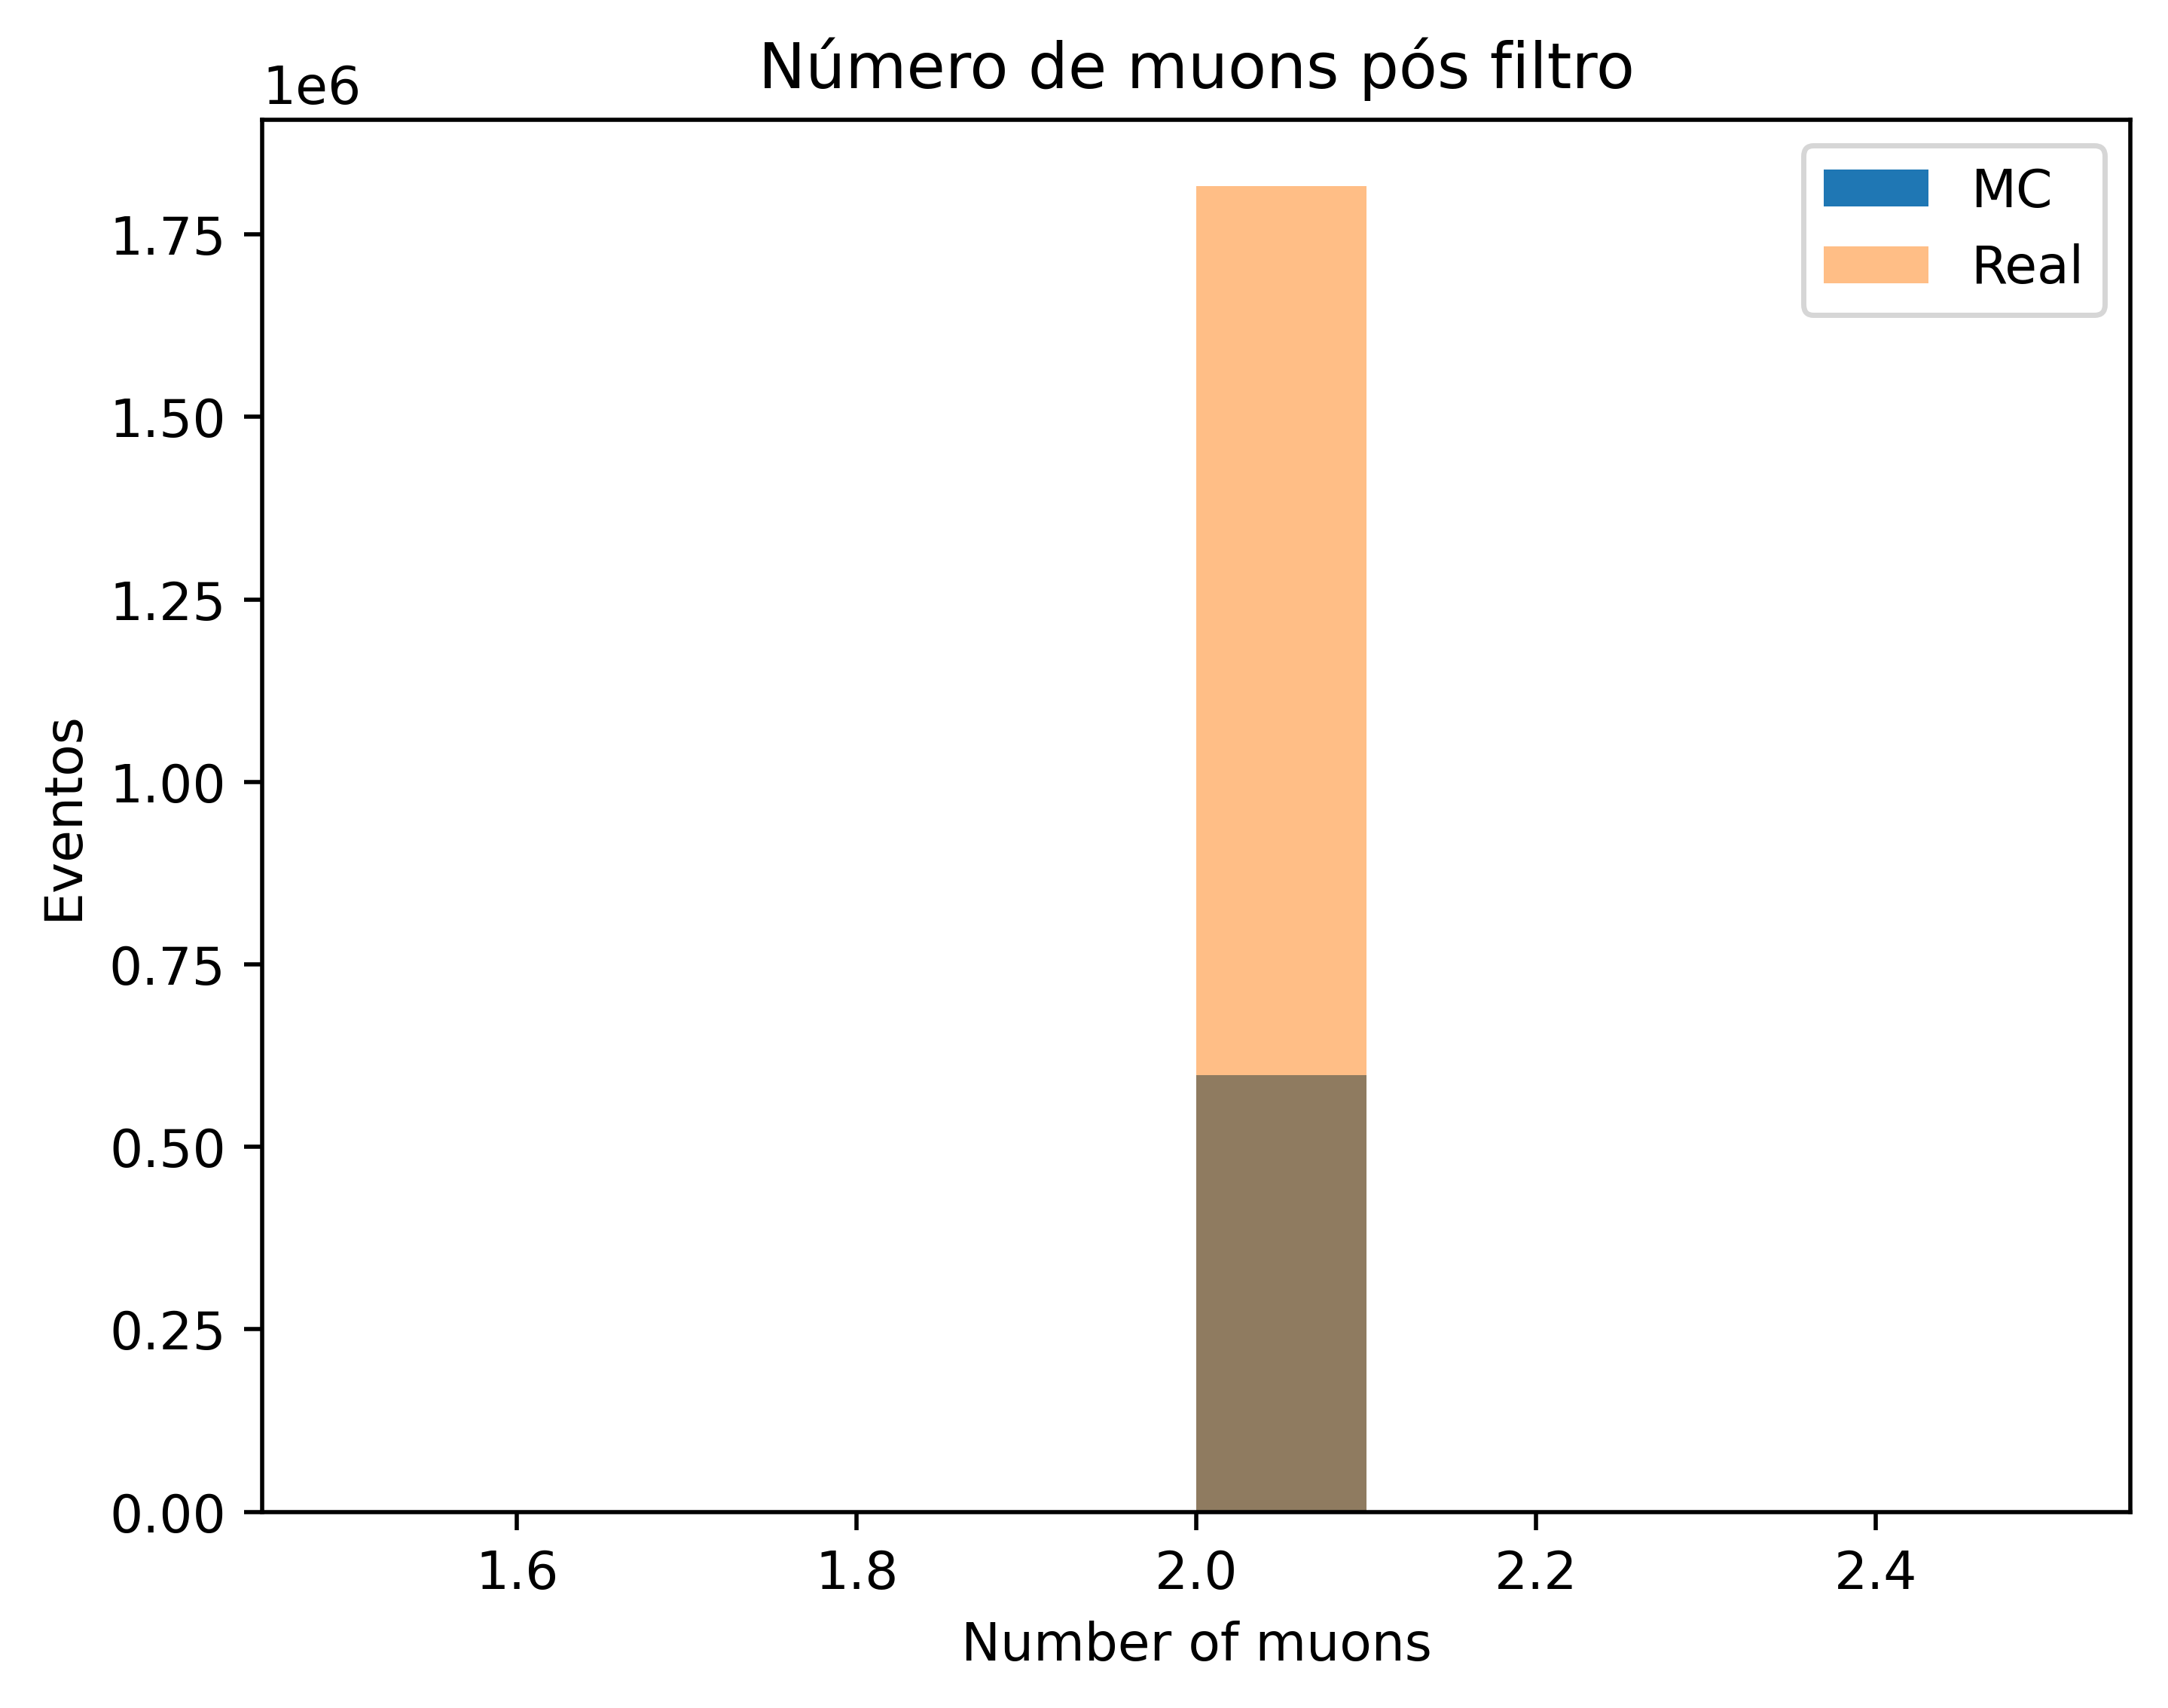

In [ ]:
plt.figure(dpi=DPI)
hist_plot(filtered, "nmuon", "Number of muons", label="MC")
hist_plot(filtered_real, "nmuon", "Number of muons", label="Real", alpha=0.5)
plt.title("Número de muons pós filtro")
plt.legend()
plt.show()

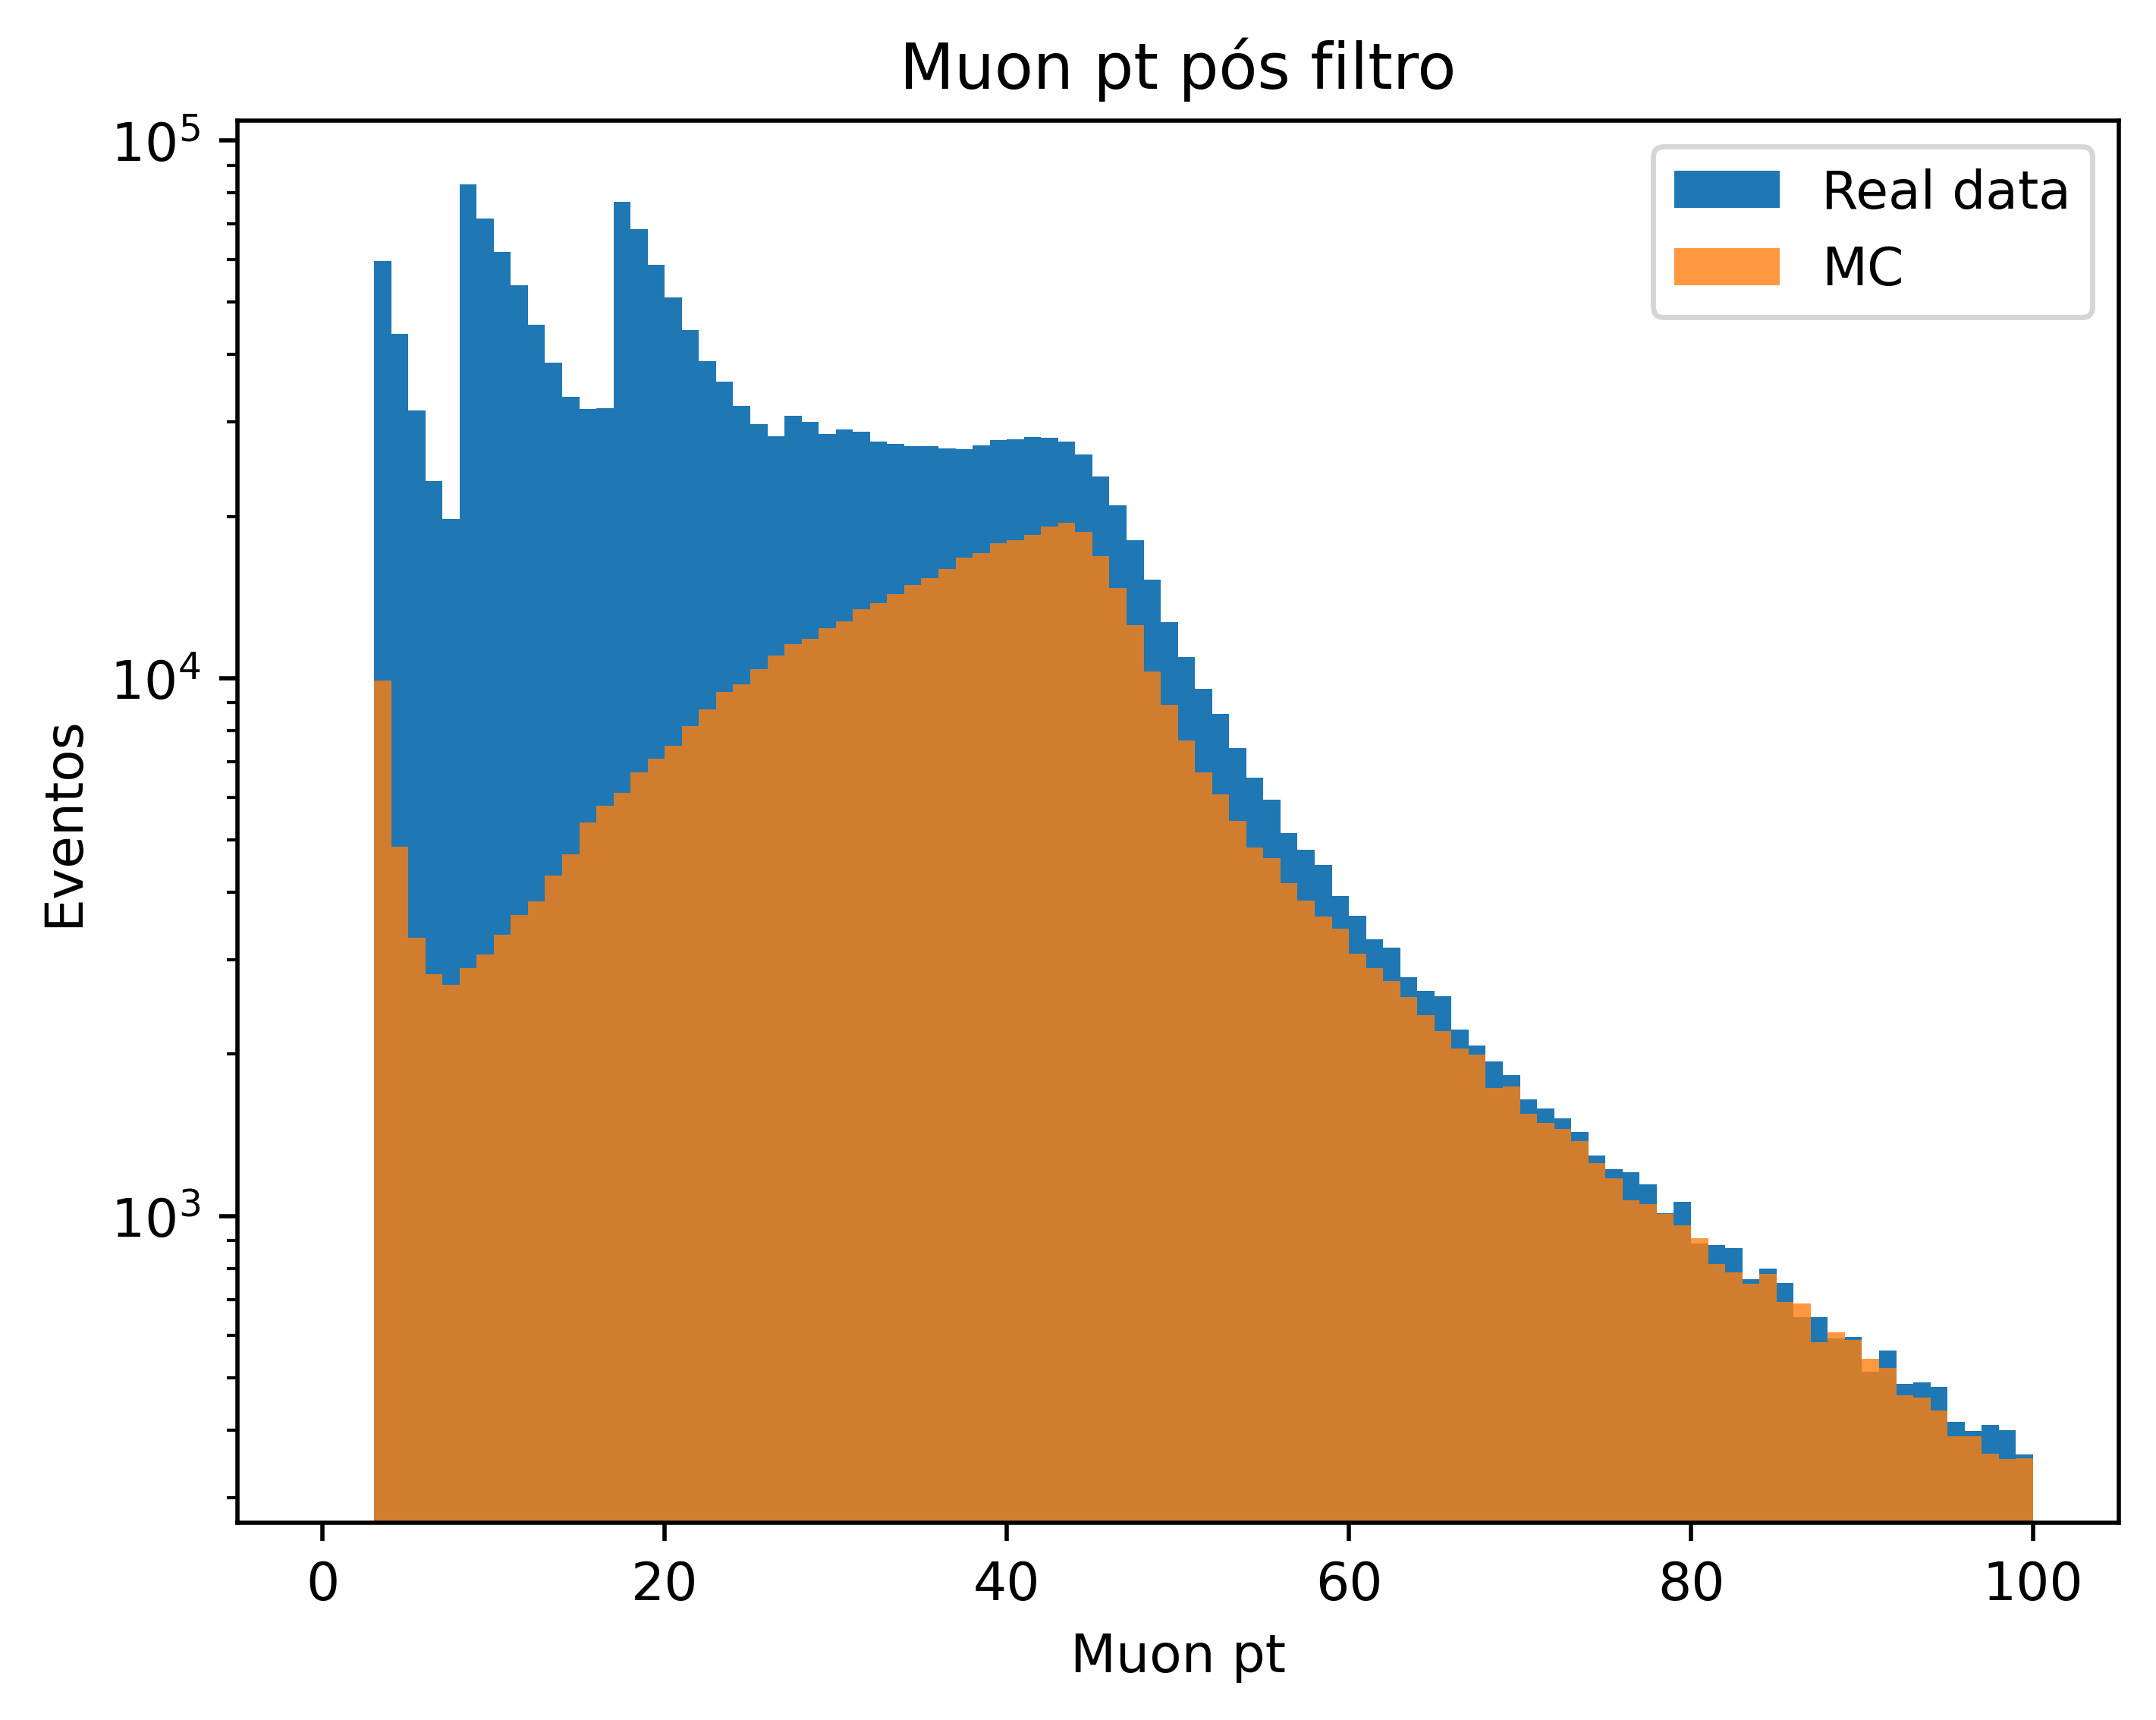

In [ ]:
plt.figure(dpi=DPI)
hist_plot(filtered_real, "pt" , "Muon pt", bins=100, range=(0, 100), log=True, label="Real data")
hist_plot(filtered, "pt" , "Muon pt", bins=100, range=(0, 100), log=True, label="MC", alpha=0.8)
plt.title("Muon pt pós filtro")
plt.legend()
plt.show()

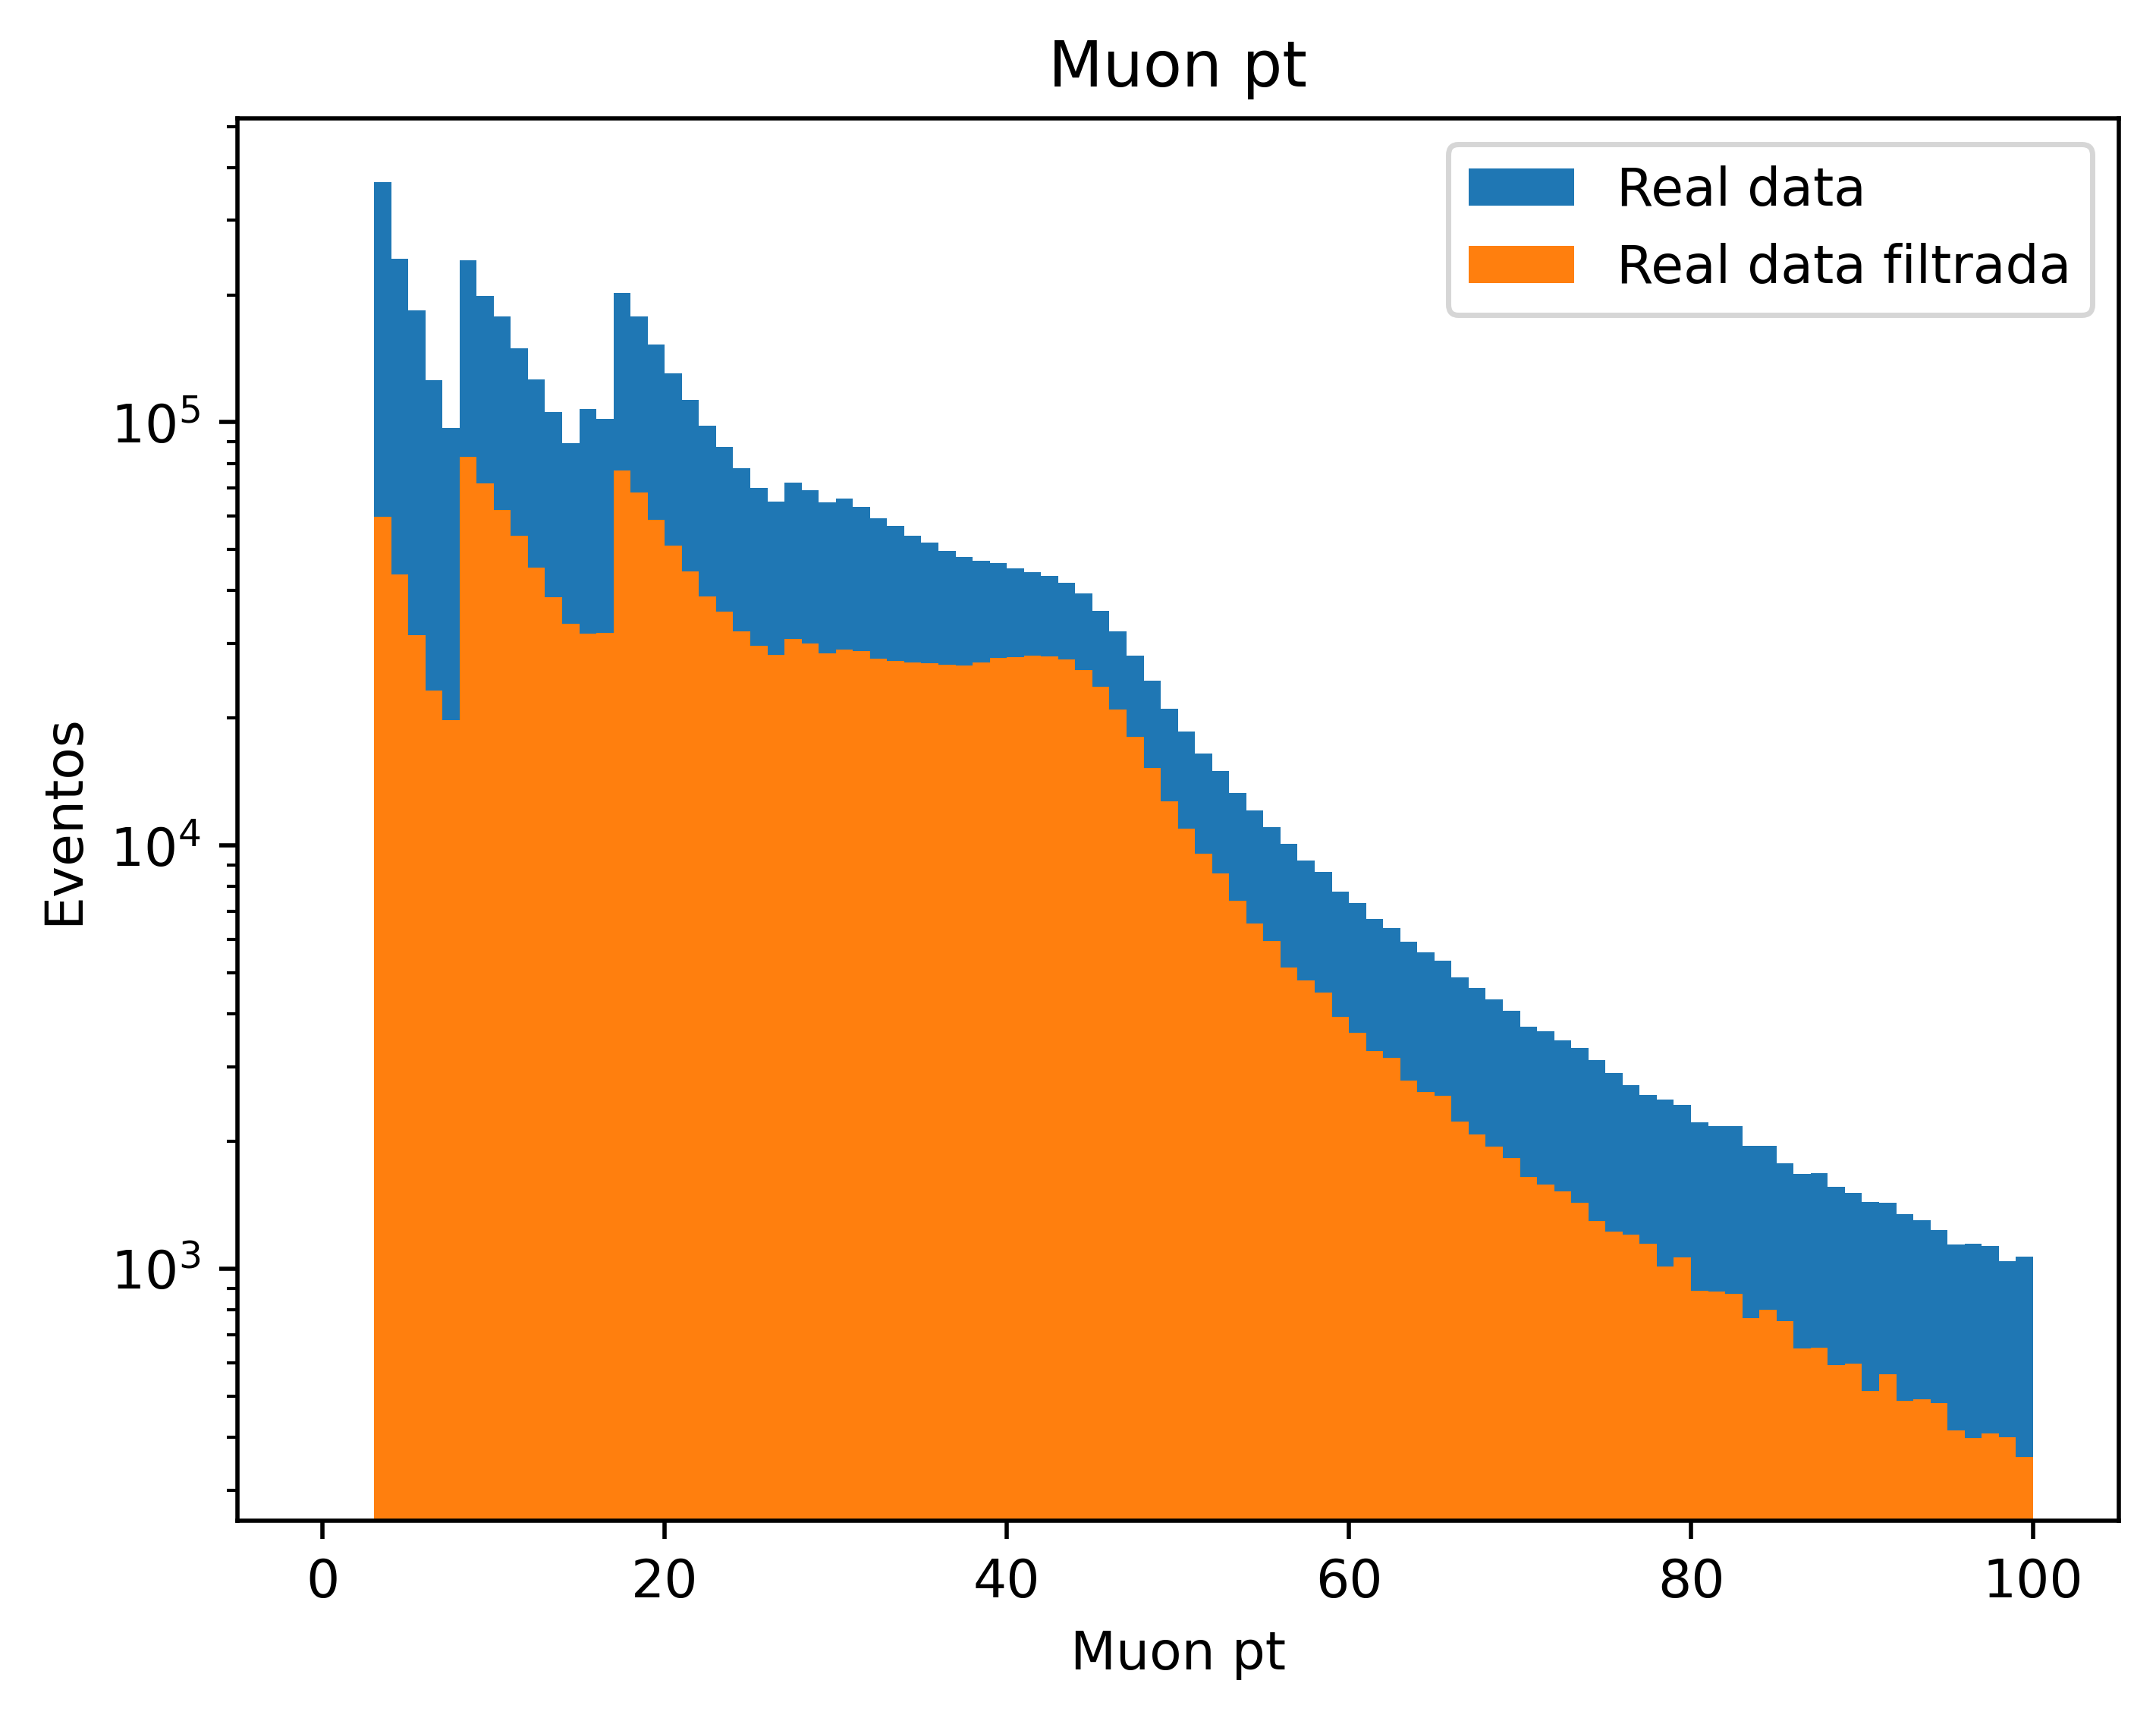

In [ ]:
plt.figure(dpi=DPI)
hist_plot(vec_real, "pt", "Muon pt", bins=100, range=(0, 100), log=True, label="Real data")
hist_plot(filtered_real, "pt", "Muon pt", bins=100, range=(0, 100), log=True, label="Real data filtrada")
plt.title("Muon pt")
plt.legend()
plt.show()

In [ ]:
mass_real = inv_mass_expand(filtered_real)
mass = inv_mass_expand(filtered)

bin_centers, hist_counts = generate_points(mass_real)

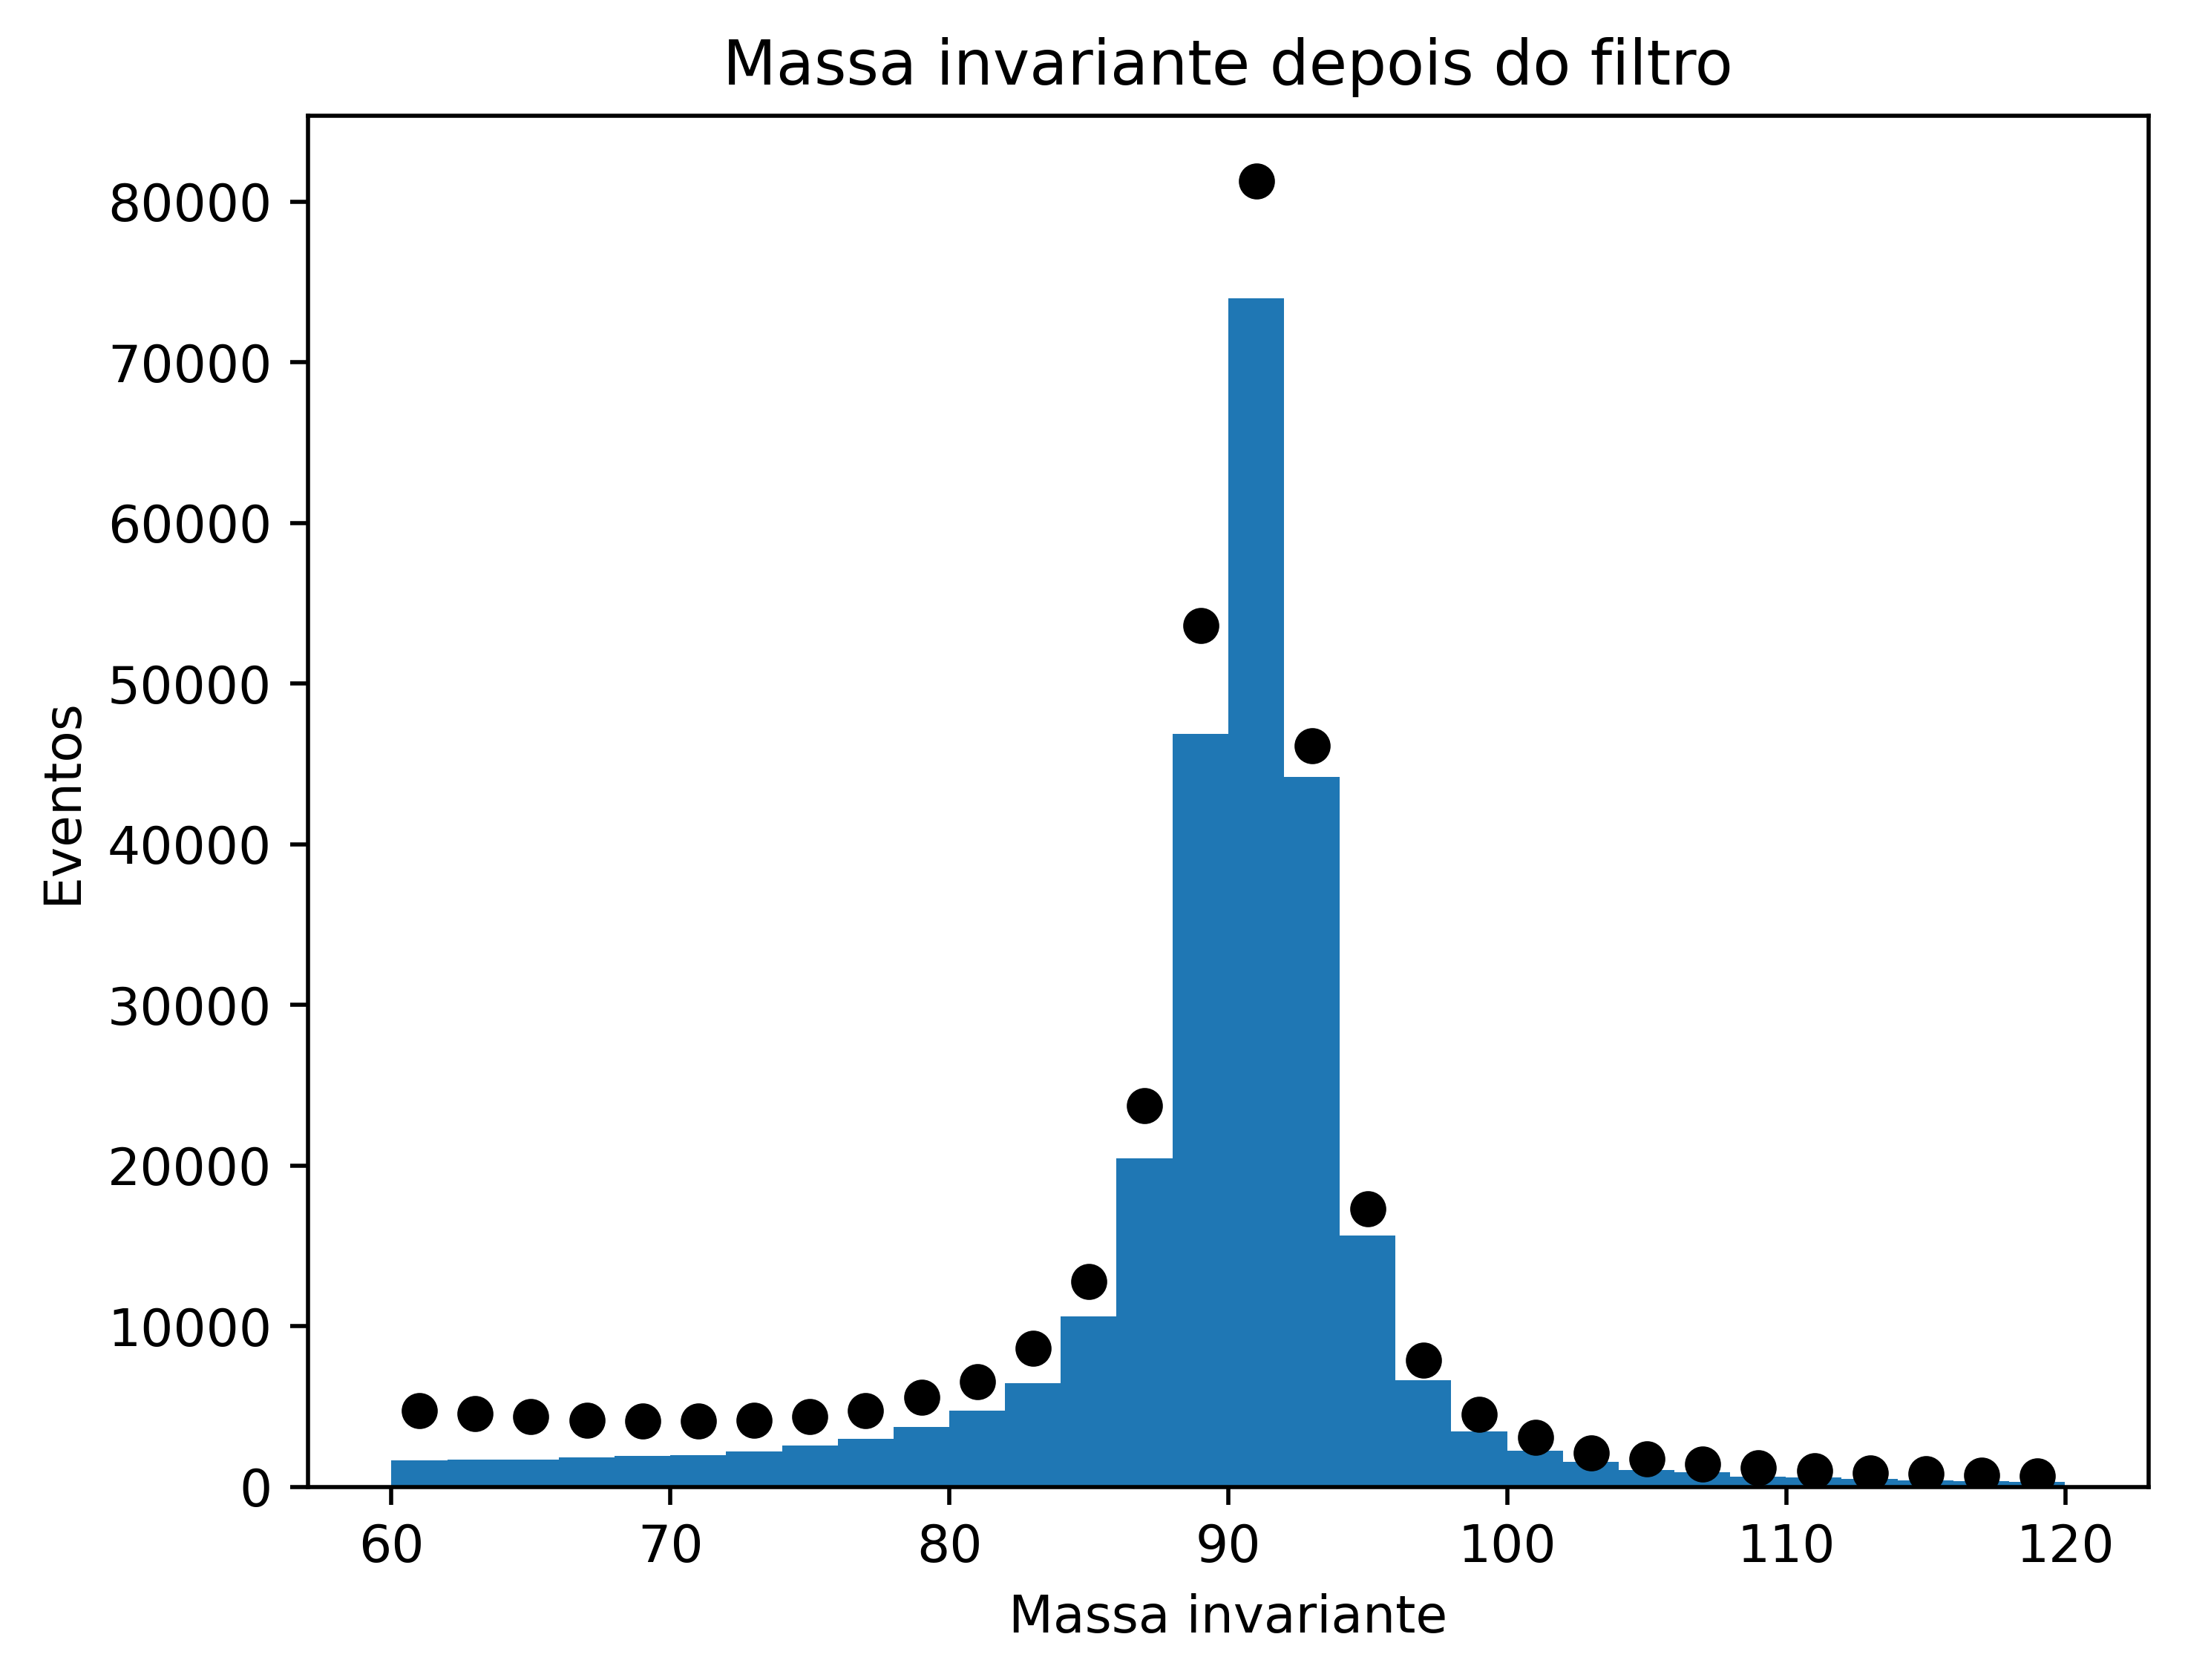

In [ ]:
plt.figure(dpi=DPI)
plt.hist(mass, bins=BINS, label="MC Data")
plt.scatter(bin_centers, hist_counts, label="real data", color="black")
plt.xlabel("Massa invariante")
plt.ylabel("Eventos")
plt.title("Massa invariante depois do filtro")
plt.show()

# FINAL DO NOTEBOOK